In [35]:
import pandas as pd
import dash
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

df_dejavnosti = pd.read_csv("data/podatki_po_dejavnostih.csv", delimiter=",", encoding="windows-1250")
df_odjemalci = pd.read_csv("data/podatki_vrsta_odjemalca.csv", delimiter=",", encoding="windows-1250")

In [36]:
df_odjemalci_backup = df_odjemalci.copy()

#Tukaj vzamemo samo podatke za VSE SKUPAJ porabo (brez gospodinjstva in poslovnih objektov)
df = df_odjemalci_backup[::+3]
#Tukaj izbrišem podatke za SLOVENIJO in Neznano vrstice
df = df[1:-1]

#Priprava podatkov za uporabo
df = df.drop("VRSTA ODJEMALCA", axis=1)
obcine = {df["OBČINE"][i]:i for i in df.index}

vse_2020 = dict(df[df.columns[1:13]].sum(axis=1))
vse_2021 = dict(df[df.columns[13:25]].sum(axis=1))
vse_2022 = dict(df[df.columns[25:34]].sum(axis=1))
dict_porab = dict([(k,[vse_2020[k], vse_2021[k], vse_2022[k]]) for k in vse_2020])

#V koncem dictu so shranjene OBČINE (ključ) z vrednostmi, ki so LISTI, 
# ki prikazujejo porabo za vsako občino za vsako leto posebaj
koncni_dict = dict()
for k,v in obcine.items():
    koncni_dict[k] = dict_porab[v]

In [37]:
def izrisi_odjemalci_Slovenija(odjemalci, leto):
    df_odjemalci = odjemalci.copy()
    #Tukaj vzamemo samo podatke za VSE SKUPAJ porabo (brez gospodinjstva in poslovnih objektov)
    df = df_odjemalci[::+3]
    #Tukaj izbrišem podatke za SLOVENIJO in Neznano vrstice
    df = df[1:-1]
    #Priprava podatkov za uporabo
    df = df.drop("VRSTA ODJEMALCA", axis=1)
    obcine = {df["OBČINE"][i]:i for i in df.index}

    dict_porab = dict()
    if leto == 2020:
        vse_2020 = dict(df[df.columns[1:13]].sum(axis=1))
        dict_porab = dict([(k,[vse_2020[k]]) for k in vse_2020])
    elif leto == 2021:
        vse_2021 = dict(df[df.columns[13:25]].sum(axis=1))
        dict_porab = dict([(k,[vse_2021[k]]) for k in vse_2021]) 
    elif leto == 2022:
        vse_2022 = dict(df[df.columns[25:34]].sum(axis=1))
        dict_porab = dict([(k,[vse_2022[k]]) for k in vse_2022]) 

    #V koncem dictu so shranjene OBČINE (ključ) z vrednostmi, ki so LISTI, 
    # ki prikazujejo porabo za vsako občino za vsako leto posebaj
    koncni_dict = dict()
    for k,v in obcine.items():
        koncni_dict[k] = dict_porab[v]

    return pd.DataFrame.from_dict(koncni_dict)

In [38]:
izrisi_odjemalci_Slovenija(df_odjemalci, 2021)

,Ajdovščina,Ankaran/Ancarano,Apače,Beltinci,Benedikt,Bistrica ob Sotli,Bled,Bloke,Bohinj,Borovnica,...,Vuzenica,Zagorje ob Savi,Zavrč,Zreče,Žalec,Železniki,Žetale,Žiri,Žirovnica,Žužemberk
0,100935906,19604562,10623990,24562474,6991660,3620303,40729710,6806006,31605428,21052894,...,35003492,63384717,3120211,92890681,137093374,39586834,2590438,26462095,17111671,18407119


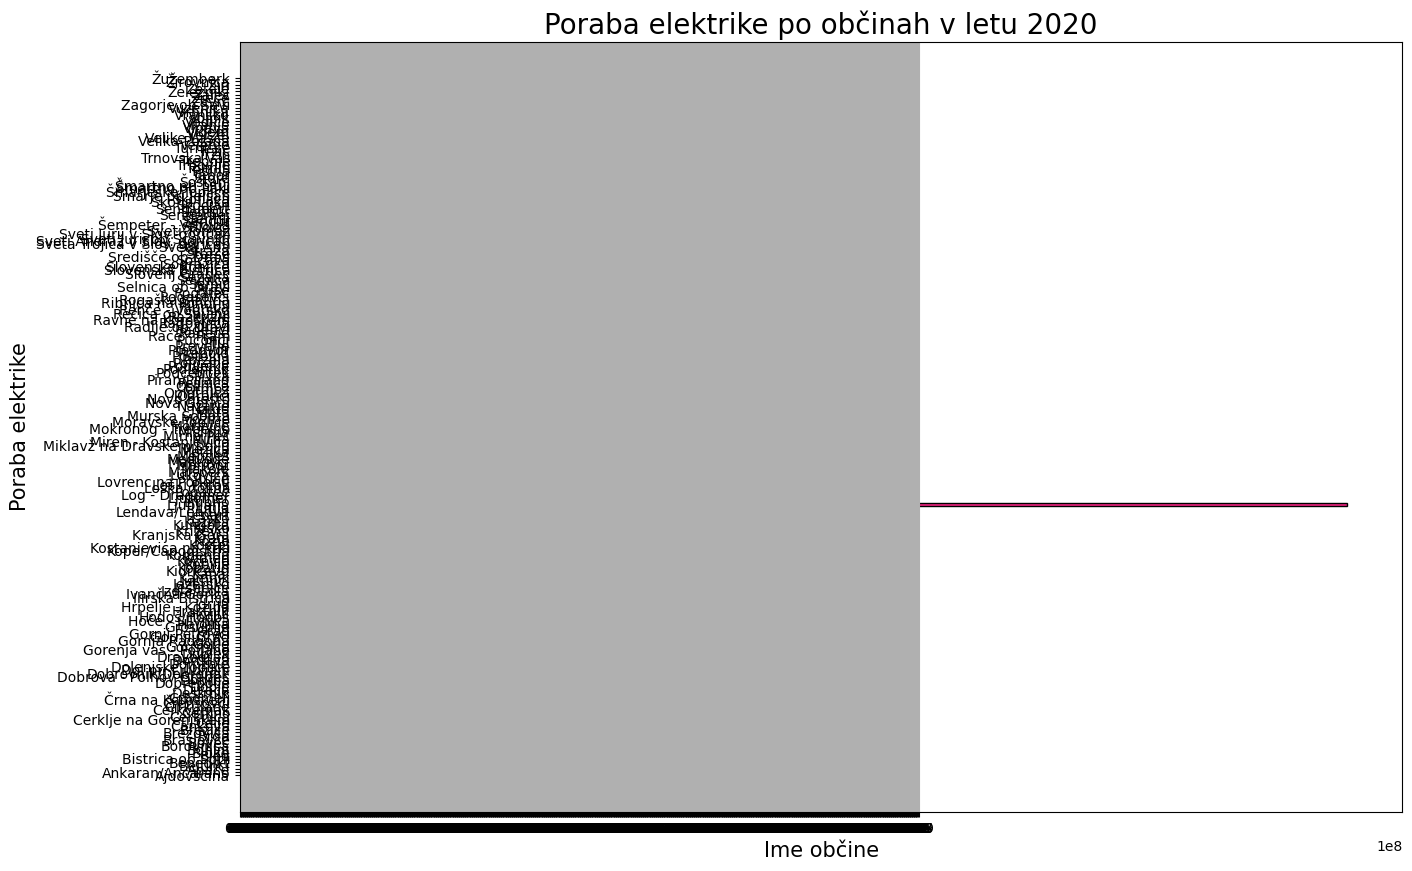

In [39]:
x = list(koncni_dict.keys())
y = list()

for value in koncni_dict.values():
    y.append(value[0])

plt.figure(figsize=(15,10))
plt.barh(x, y, color='#F72585', edgecolor='black')
plt.grid(axis='x')
plt.xticks(np.arange(0, 1000000000, step=1000000))
plt.title('Poraba elektrike po občinah v letu 2020', fontsize=20)
plt.xlabel('Ime občine', fontsize=15)
plt.ylabel('Poraba elektrike', fontsize=15)
plt.show()
